# Twitter Sentiment Analysis
Using:
* twint for scraping twitter
* kafka for streaming the tweets
* spark for collecting the tweets
* vaderSentiment for Sentiment Analysis
* plotly for data plotting

## Spark
In this cell we will initiate spark session

In [1]:
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import explode, split, col, from_json, date_trunc, trunc, udf, avg
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, FloatType
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.context import SQLContext

import pyspark

In [2]:
spark = SparkSession.builder.appName("TwitterSentimentAnalysis") \
          .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.2") \
    .config('spark.streaming.stopGracefullyOnShutdown', 'true')\
    .config("spark.driver.memory","8G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .getOrCreate()

The funcition get_topic_df will return pyspark dataframe that is subscribed to a specific Topic

In [3]:
broker_url = "broker:9092"

schema_input = StructType([
    StructField('created_at', LongType(), True),
    StructField('tweet', StringType(), True)
])

def get_topic_df(topic_name):
    # Read the data from kafka
    df = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", broker_url) \
        .option("subscribe", topic_name) \
        .option("startingOffsets", "latest") \
        .option("maxOffsetsPerTrigger", 10000) \
        .load()

    # Convert the datatype for value to a string
    string_df = df.selectExpr("CAST(value AS STRING)")

    # Select only the jsonData column, and transform using the defined schema
    json_df = string_df.withColumn("jsonData", from_json(col("value"),  schema_input)).select("jsondata.*")
    
    # Transform created_at Long column into Timestamp column, and add timestamp_trunc column truncated to the minute
    json_df = json_df.withColumn("timestamp",(col("created_at")/1000).cast("timestamp")).withColumn( "timestamp_trunc", date_trunc("minute", col("timestamp")) )

    return json_df

## Sentiment Analysis

We will [vaderSentiment](https://github.com/cjhutto/vaderSentiment) library to analyse the sentiment in the tweets collected<br>
This library gives us 4 metrics:
1. positive score
2. Neutral score
3. Negative score
4. Compound score

According to the docs, the thresholds used for classification are:
1. positive sentiment: compound score >= 0.05
2. neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
3. negative sentiment: compound score <= -0.05


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

We define a User Defined Function (udf) called npl_udf that will use the vaderSentiment for Sentiment Analysis

In [5]:
analyzer = SentimentIntensityAnalyzer()

import pandas as pd
import json

def analyze_tweet(text):
    vs = analyzer.polarity_scores(text)
    return json.dumps(vs)

npl_udf = udf(lambda data: analyze_tweet(data), StringType())

## Spark + NLP

Now we combine both Spark and NLP to analyze the tweets received from Kafka.<br>
The function get_nlp_df will add nlp results to the input pyspark df by calling npl_udf

In [6]:
schema_output = StructType([
    StructField('neg', FloatType(), True),
    StructField('neu', FloatType(), True),
    StructField('pos', FloatType(), True),
    StructField('compound', FloatType(), True)])

def get_nlp_df(df):
    # Add the npl_udf returned information to the dataframe
    return df.select('*',from_json(npl_udf(col('tweet')), schema_output).alias('response'))

The function get_count_df will return a pyspark datafrmame holding the number of tweets per minute

In [7]:
def get_count_df(df):
    return df.withWatermark("timestamp_trunc", "1 minutes") \
                    .groupBy("timestamp_trunc").count()

The function get_avg_df returns a pyspark dataframe holding the average compound score per minute

In [8]:
def get_avg_df(df):
    return df.withWatermark("timestamp_trunc", "1 minutes") \
                    .groupby("timestamp_trunc").agg(avg('response.compound').alias('avg_compound'))

Finally, the function monitor topic, will bring all the previous functions together.<br>
It will save the tweet counts, and average compound score to a memory table for plotting later

In [9]:
def monitor_topic(topic_name):
    json_df = get_topic_df(topic_name)
    count_df = get_count_df(json_df)
    nlp_df = get_nlp_df(json_df)
    avg_df = get_avg_df(nlp_df)

    avg_df.writeStream.format("memory").queryName(f'avg_comp_{topic_name}').start()
    count_df.writeStream.format("memory").queryName(f'count_tweets_{topic_name}').start()

We will use the monitor_topic function to monitor Trend_1 and Trend_2

In [10]:
monitor_topic('Trend_1')
monitor_topic('Trend_2')

## Trending on Twitter
We will what's tranding on twitter from a shared csv file

In [11]:
import pandas as pd

trending_df = pd.read_csv('/home/jovyan/work/scripts/trends.csv')

def get_subject(topic_name):
    return trending_df[trending_df['Topic'] == topic_name]['Subject'].tolist()[0]
    

## Plotting

## <span style='color:red'>Important</span>
<p style='color:red'>The plots will take a couple minutes to start looking intereting, since the watermark is every 1 minute</p> 

The function plot_topic will read the accumulated data from memory table, and plot the graphs, updating the data every one 

In [12]:
%matplotlib widget

import matplotlib.pyplot as plt
import threading
import time

In [13]:
def get_avg_sql_df(topic_name):
    avg_df = spark.sql(f'select * from avg_comp_{topic_name} order by timestamp_trunc desc').toPandas()
    return avg_df.rename(columns={'timestamp_trunc':'Timestamp','avg_compound':'Average Compound Score'})

def get_count_sql_df(topic_name):
    count_df = spark.sql(f'select * from count_tweets_{topic_name} order by timestamp_trunc desc').toPandas()
    return count_df.rename(columns={'timestamp_trunc':'Timestamp','count':'Tweets Count'})

def plot_topic(topic_name):
    
    plt.ion()
    avg_df = get_avg_sql_df(topic_name)
    count_df = get_count_sql_df(topic_name)

    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot(121)
    line1, = ax.plot(avg_df['Timestamp'], avg_df['Average Compound Score'], marker='o')
    plt.grid()
    plt.xlabel("Timestamp")
    plt.ylabel("Average Compound Score")
    plt.title(f"Average Compound Score over Time for \"{get_subject(topic_name)}\"")
    
    ax = fig.add_subplot(122)
    line2, = ax.plot(count_df['Timestamp'], count_df['Tweets Count'], marker='o')
    plt.grid()
    plt.xlabel("Timestamp")
    plt.ylabel("Tweets Count")
    plt.title(f"Tweets Count over Time for \"{get_subject(topic_name)}\"")
    
    return line1, line2, fig


The function plot_topic will plot the average compound score over time, and tweet count over time

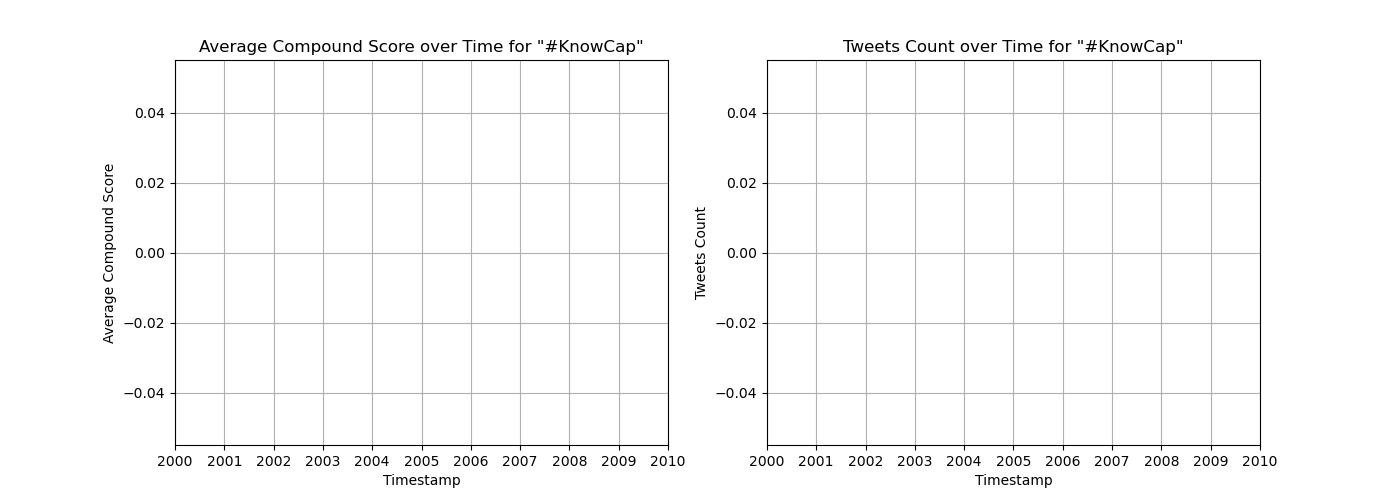

In [14]:
line1_1, line1_2, fig1 = plot_topic('Trend_1')

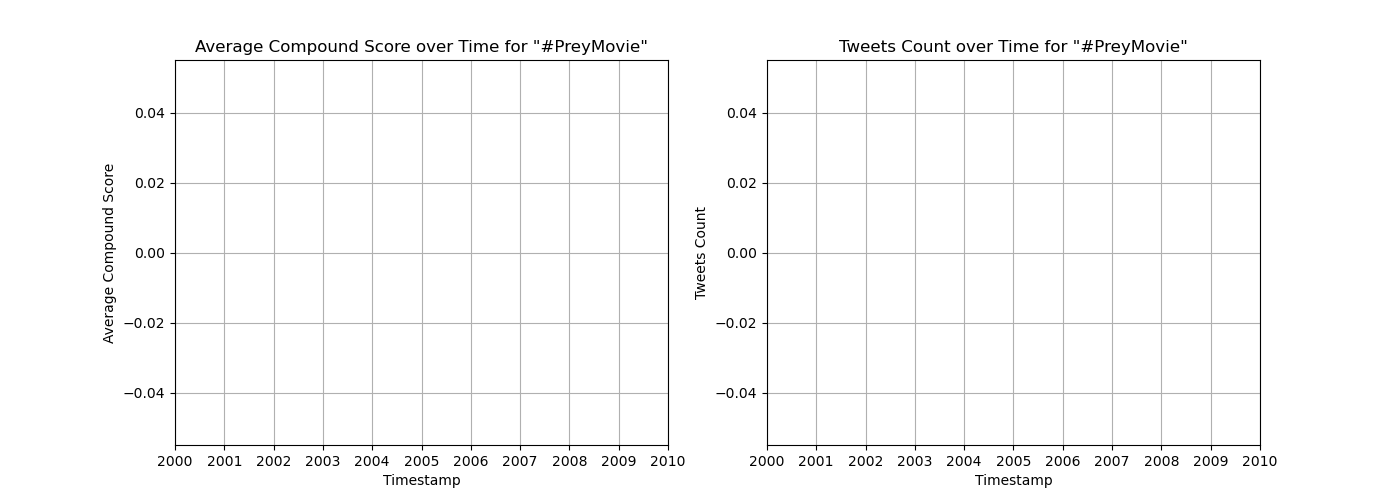

In [15]:
line2_1, line2_2, fig2 = plot_topic('Trend_2')

The refresh function is used to keep updating the plots using up-to-date data

In [16]:
import logging as logger

In [17]:
logger.basicConfig(filename='/home/jovyan/work/refresh.log', level=logger.INFO)

def refresh(topic_name, line1, line2, fig):
    while True:
        time.sleep(10)
        logger.info(f'Running refresh for {topic_name}')

        avg_df = get_avg_sql_df(topic_name)
        count_df = get_count_sql_df(topic_name)
        logger.info(f'Got updated data for {topic_name}')
        
        if len(avg_df) < 1:
            logger.info(f'No data yet for {topic_name}')
        else:
            line1.set_xdata(avg_df['Timestamp'])
            line1.set_ydata(avg_df['Average Compound Score'])
            fig.axes[0].set_xlim(avg_df.iloc[[-1,0]]['Timestamp'].tolist())
            fig.axes[0].set_ylim([avg_df['Average Compound Score'].min(),avg_df['Average Compound Score'].max()])

            line2.set_xdata(count_df['Timestamp'])
            line2.set_ydata(count_df['Tweets Count'])
            fig.axes[1].set_xlim(count_df.iloc[[-1,0]]['Timestamp'].tolist())
            fig.axes[1].set_ylim([count_df['Tweets Count'].min(),count_df['Tweets Count'].max()])

            fig.canvas.draw()
            fig.canvas.flush_events()
            logger.info(f'Finished refresh for {topic_name}')

We will run a background thread for each topic we are monitoring and plotting, to refresh the plots

In [18]:
threading.Thread(target=refresh, args=(['Trend_1',line1_1, line1_2, fig1])).start()
threading.Thread(target=refresh, args=(['Trend_2',line2_1, line2_2, fig2])).start()

## Conclusion

Using twint, we were able to scrape all new tweets related to the top 2 trending subjects on twitter in the USA.<br>
These tweets are then shared over separate kafka topics, and collected using pyspark.<br>
The tweets are then analyzed using vaderStatement, aggregated and stored into memory, to be read into Pandas DataFrames and plotted using matplotlib.<br>

Regarding the plots, for each topic, we have 2 plots.
1. Average Compound score over time
   This plot allows us to see the public perception of the subject, are people talking about this subject in a positive or negative manner?
2. Tweet Count over time
   This plot shows us the progress of the interest in the subject, is it growing or declining?